# **Active Object Localization with Deep Reinforcement Learning**

In [0]:
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

#Download required dataset / competition files to a folder of your choice
!kaggle datasets download -d huanghanchina/pascal-voc-2012 -p /content/pascal

Saving kaggle.json to kaggle.json
kaggle.json
100% 3.62G/3.63G [01:06<00:00, 61.6MB/s]
100% 3.63G/3.63G [01:06<00:00, 58.7MB/s]


**Extracting the zip file:**

In [0]:
""" It may take some time to extract the dataset zip. Plz be patient ! """
#!pwd
import os
os.chdir('./pascal')  #change dir
!unzip -q pascal-voc-2012.zip

**Install and import necessary libraries:**

In [0]:
!pip install xmltodict

In [0]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import sys
import xmltodict
import math
import random
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt

**Prepare and loading images from dataset along with their bounding boxes:**

In [0]:

def get_object_name(object_number):
    """
    Converting object's id to object's name
    """
    dictionary={ 1:'aeroplane' , 2:'bicycle', 3:'bird', 4:'boat', 
                 5:'bottle' , 6:'bus', 7:'car', 8:'cat', 9:'chair', 
                 10:'cow', 11:'diningtable', 12:'dog' , 13:'horse', 
                 14:'motorbike', 15:'person', 16:'pottedplant',
                 17:'sheep', 18:'sofa', 19:'train', 20:'tvmonitor'}

    return dictionary[object_number]

def read_image_index(object_name, dataset_path, test):
    """
    Reading the name of images from the txt file of target object
    """
    index_list = []
    if test:
      index_file_path = dataset_path + "ImageSets/Main/" + object_name + "_trainval.txt"
    else:
      index_file_path = dataset_path + "ImageSets/Main/" + object_name + "_train.txt"
    with open(index_file_path, 'r') as f:
        for line in f:
            #only consider those images that consist of the class (aeroplane) we are interested in.
            if "-1" not in line.split(" ")[1]:
                index_list.append(line.split(" ")[0])

    return index_list

def read_image(image_index, dataset_path):
    """
    Loading images using their name from JPEGImages folder
    """
    image_list = []
    image_folder_path = dataset_path + "JPEGImages/"
    for each_image in image_index:
        img = cv2.imread(image_folder_path + each_image + ".jpg")
        image_list.append(img)

    return image_list


def load_annotation(image_index, object_name, dataset_path):

    """
    Loading bounding boxes around objects in images
    """
    bounding_box_list = []
    annotattion_path = dataset_path + "Annotations/"
    for each_image in image_index:
        path = annotattion_path + each_image + ".xml"
        xml = xmltodict.parse(open(path, 'rb'))
        xml_objects = xml['annotation']['object']
        if isinstance(xml_objects, list):
            for each_object in xml_objects:

                if each_object["name"] == object_name:
                    xmin = each_object["bndbox"]["xmin"]
                    ymin = each_object["bndbox"]["ymin"]
                    xmax = each_object["bndbox"]["xmax"]
                    ymax = each_object["bndbox"]["ymax"]
                    bounding_box = (int(xmin), int(ymin), int(xmax), int(ymax))
                    bounding_box_list.append(bounding_box)
                    break
        else:
            if xml_objects["name"] == object_name:
                xmin = xml_objects["bndbox"]["xmin"]
                ymin = xml_objects["bndbox"]["ymin"]
                xmax = xml_objects["bndbox"]["xmax"]
                ymax = xml_objects["bndbox"]["ymax"]
                bounding_box = (int(xmin), int(ymin), int(xmax), int(ymax))
                bounding_box_list.append(bounding_box)

    return bounding_box_list


def load_data(object_number, test):

    """
    Loading dataset images for a specific class by calling corresponding functions
    and saving images and their annotations into arrays
    """ 
    dataset_path = "./VOC2012/"
    object_name = get_object_name(object_number)  
    image_index = read_image_index(object_name, dataset_path,test)
    #print(len(image_index))
    image_list = np.asarray(read_image(image_index, dataset_path))
    bounding_box_list = np.asarray(load_annotation(image_index, object_name, dataset_path))
    
    if test:
      np.save(object_name + "_valimage.npy", image_list)
      np.save(object_name + "_valbox.npy", bounding_box_list)

    else:
      np.save(object_name + "_image.npy", image_list)
      np.save(object_name + "_box.npy", bounding_box_list)

    return image_list, bounding_box_list


**Showing some pictures from 20 classes of dataset:**

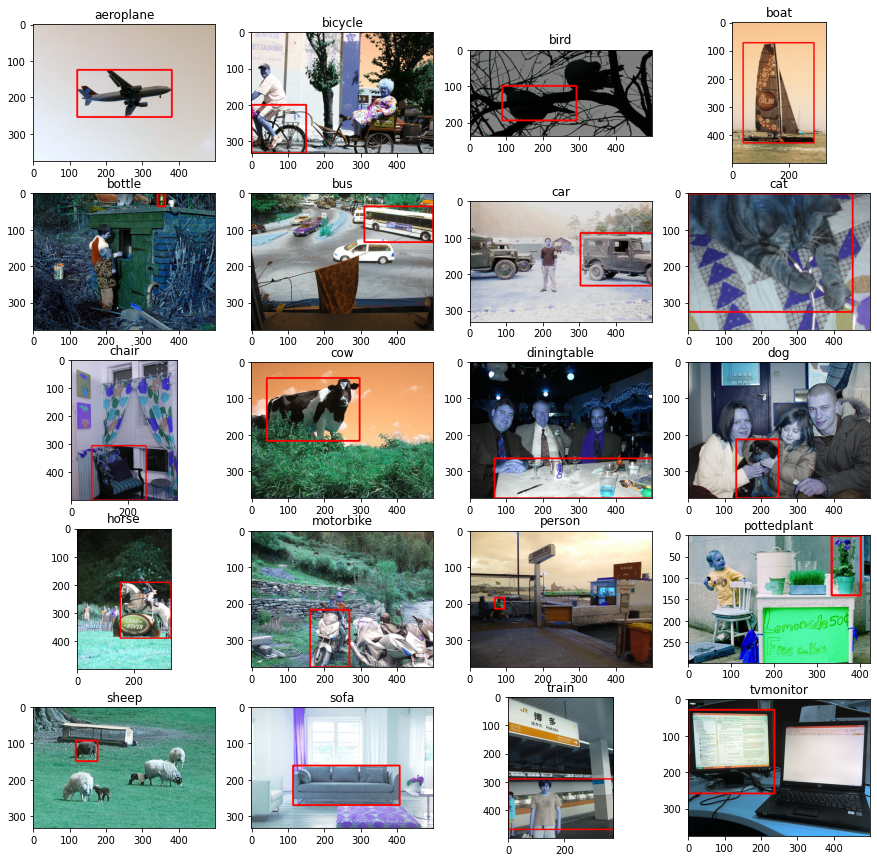

In [0]:
plt.figure(figsize=(15,15))
for i in range(1,21):
    plt.subplot(5,4,i)
    image_list, bounding_box_list = load_data(i,test=False)
    im = image_list[15]
    # Draw a rectangle with blue line borders of thickness of 1 px
    mask = cv2.rectangle(im, (bounding_box_list[15][0], bounding_box_list[15][1]), (bounding_box_list[15][2], bounding_box_list[15][3])  , (255, 0, 0) , 3) 
    masked_data = cv2.bitwise_and(im, im, mask)
    plt.imshow(masked_data)
    label = get_object_name(i)
    plt.title(str(label))
plt.show()

**Showing 10 sample test images (this funciton is called after training the agent and testing it on 100 test images)**

In [0]:
def test2():
    object_number = 1
    image_list, bounding_box_list = load_data(object_number , test=True)
    iou = []
    vgg16 = create_vgg16()
    deep_q = create_q_model()
    deep_q.load_weights("my_tmp_model.h5")

    for i in range(30,40):
        bounding_box = bounding_box_list[i]
        image = image_list[i]
        history = [-1] * history_size
        height, width, channel = np.shape(image)
        current_mask = np.asarray([0, 0, width, height])
        feature = extract_feature(image, history, vgg16)
        end = False
        masks = []
        step = 0
        
        while not end:

            q_value = compute_q(feature, deep_q)

            action = np.argmax(q_value)

            history = history[1:]
            history.append(action)

            if action == 8 or step == 10: #steps should be changed to 40
                end = True
                #print("end")
                plt.figure()
                new_mask = current_mask
                cv2.rectangle(image, (int(new_mask[0]), int(new_mask[1])),
                              (int(new_mask[2]), int(new_mask[3])), (255, 0, 0), 1)
                '''cv2.imwrite("./result/plane_result%d.jpg" % i, image)
                plt.imshow(image)'''
                predicted_box = cv2.rectangle(image, (int(new_mask[0]), int(new_mask[1])),
                              (int(new_mask[2]), int(new_mask[3])), (0, 0, 255), 2)
                #predicted_result = cv2.bitwise_and(image, image, predicted_box)

                groundtruth= cv2.rectangle(image, (int(bounding_box[0]), int(bounding_box[1])),
                              (int(bounding_box[2]), int(bounding_box[3])), (0, 255, 0), 2)
                test_result = cv2.bitwise_and(image, image, groundtruth)
                
                plt.imshow(test_result)
                plt.title('predicted box is shown in bold blue and ground truth box is shown in bold green \n Search path shown in red')
                plt.show()

            else:
                new_mask = compute_mask(action, current_mask)

            cropped_image = crop_image(image, new_mask)
            feature = extract_feature(cropped_image, history, vgg16)

            masks.append(new_mask)
            current_mask = new_mask
            cv2.rectangle(image, (int(current_mask[0]), int(current_mask[1])),
                          (int(current_mask[2]), int(current_mask[3])), (255, 0, 0), 1)
            step += 1

        mask = masks[-1]
        iou.append(compute_iou(mask,bounding_box))


    print(sum(iou)/len(iou))
    pd.DataFrame(iou).to_excel('output.xlsx', header=False, index=False)


**Testing the agent on 100 test images and calculating the average iou:**

In [0]:
from google.colab.patches import cv2_imshow


def test():
    object_number = 1
    image_list, bounding_box_list = load_data(object_number , test=True)
    iou = []
    vgg16 = create_vgg16()
    deep_q = create_q_model()
    deep_q.load_weights("my_tmp_model.h5")

    for i in range(0,100):
        bounding_box = bounding_box_list[i]
        image = image_list[i]
        history = [-1] * history_size
        height, width, channel = np.shape(image)
        current_mask = np.asarray([0, 0, width, height])
        feature = extract_feature(image, history, vgg16)
        end = False
        masks = []
        step = 0

        while not end:

            q_value = compute_q(feature, deep_q)

            action = np.argmax(q_value)

            history = history[1:]
            history.append(action)

            if action == 8 or step == 10:
                end = True
                print("end")
                new_mask = current_mask
                cv2.rectangle(image, (int(bounding_box[0]), int(bounding_box[1])),
                              (int(bounding_box[2]), int(bounding_box[3])), (0, 0, 255), 1)
                cv2.imwrite("./result/plane_result%d.jpg" % i, image)
            else:
                new_mask = compute_mask(action, current_mask)

            cropped_image = crop_image(image, new_mask)
            feature = extract_feature(cropped_image, history, vgg16)

            masks.append(new_mask)
            current_mask = new_mask
            cv2.rectangle(image, (int(current_mask[0]), int(current_mask[1])),
                          (int(current_mask[2]), int(current_mask[3])), (0, 255, 0), 1)
            step += 1

        mask = masks[-1]
        iou.append(compute_iou(mask,bounding_box))


    print(sum(iou)/len(iou))
    pd.DataFrame(iou).to_excel('output.xlsx', header=False, index=False)
    cv2.rectangle(image, (int(mask[0]), int(mask[1])),
                   (int(mask[2]),int(mask[3])),(0, 255, 0), 2)
    cv2_imshow(image)
    cv2.waitKey()
    cv2.destroyAllWindows()


**Training the agent:** 
(to see the images of test results scroll down in the output box)

553467904/553467096 [==============================] - 4s 0us/step
Now starting epoch 1
Image 0, total reward 5
Image 1, total reward 8
Image 2, total reward 15
Image 3, total reward 13
Image 4, total reward 8
Image 5, total reward 3
Image 6, total reward 12
Image 7, total reward 11
Image 8, total reward 3
Image 9, total reward 3
loss 69.67517905533313
Image 10, total reward 21
Image 11, total reward 4
Image 12, total reward 8
Image 13, total reward 6
Image 14, total reward 13
Image 15, total reward 9
Image 16, total reward 5
Image 17, total reward 11
Image 18, total reward 10
Image 19, total reward 3
Image 20, total reward 3
Image 21, total reward 3
loss 2.7922549134492876
Image 22, total reward 18
Image 23, total reward 17
Image 24, total reward 7
Image 25, total reward 13
Image 26, total reward 13
Image 27, total reward 4
Image 28, total reward 13
Image 29, total reward 7
current epsilon is 0.900000
Now starting epoch 2
Image 0, total reward 4
Image 1, total reward 3
Image 2, total 

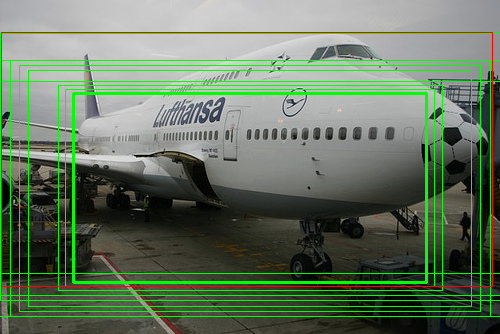

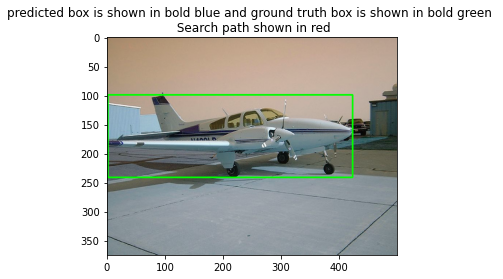

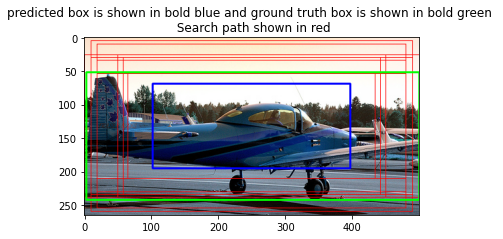

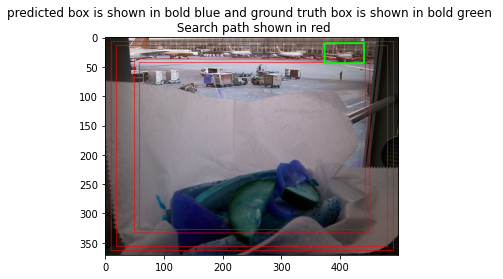

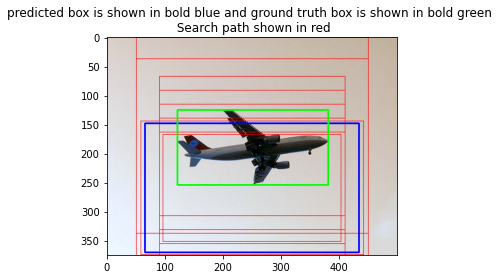

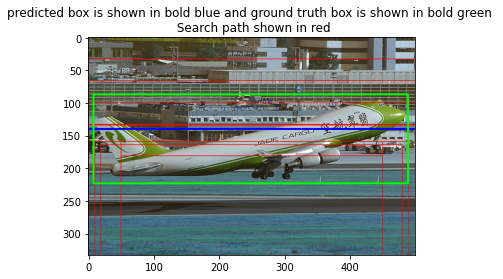

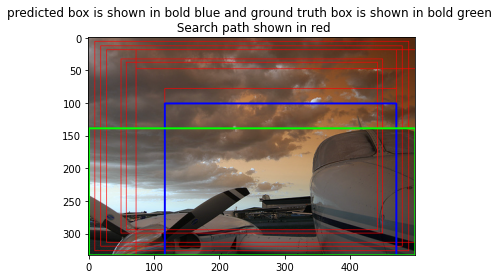

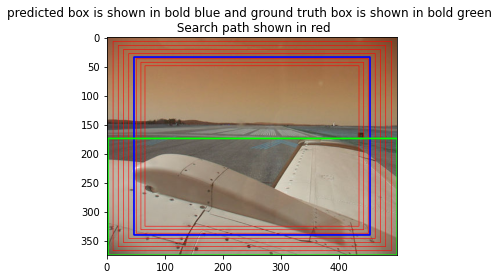

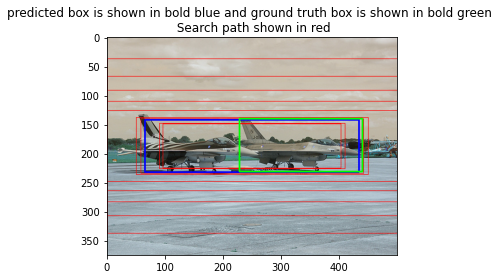

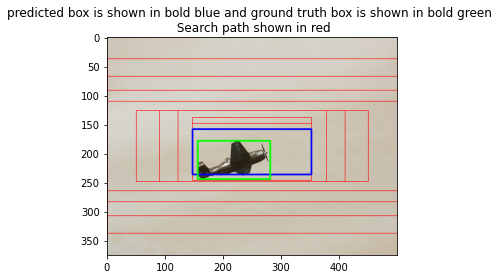

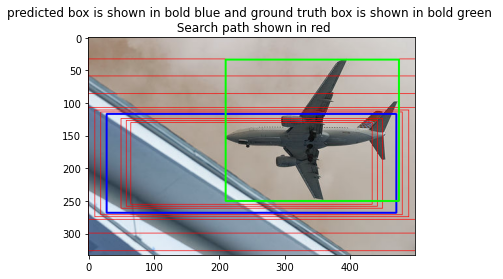

0.33197122796437223


In [0]:
history_size = 10
action_option = 9
max_steps = 20
experience_sample_size = 20
max_experience_size = 1000
gamma = 0.1
epsilon_change_steps = 10
loss_arr = []


def extract_feature(image, history, vgg16):
    history_feature = np.zeros(action_option * history_size)
    for i in range(history_size):
        if history[i] != -1:
            history_feature[i * action_option + history[i]] = 1

    feature_extractor = K.function([vgg16.layers[0].input], [vgg16.layers[20].output])
    image_reshape = [(cv2.resize(image, (224, 224))).reshape(1, 224, 224, 3)]
    image_feature = feature_extractor(image_reshape)[0]
    image_feature = np.ndarray.flatten(image_feature)
    feature = np.concatenate((image_feature, history_feature))

    return np.array([feature])


def compute_q(feature, deep_q_model):
    output = deep_q_model.predict(feature)
    return np.ndarray.flatten(output)


def compute_mask(action, current_mask):
    image_rate = 0.1
    delta_width = image_rate * (current_mask[2] - current_mask[0])
    delta_height = image_rate * (current_mask[3] - current_mask[1])
    dx1 = 0
    dy1 = 0
    dx2 = 0
    dy2 = 0

    if action == 0:
        dx1 = delta_width
        dx2 = delta_width
    elif action == 1:
        dx1 = -delta_width
        dx2 = -delta_width
    elif action == 2:
        dy1 = delta_height
        dy2 = delta_height
    elif action == 3:
        dy1 = -delta_height
        dy2 = -delta_height
    elif action == 4:
        dx1 = -delta_width
        dx2 = delta_width
        dy1 = -delta_height
        dy2 = delta_height
    elif action == 5:
        dx1 = delta_width
        dx2 = -delta_width
        dy1 = delta_height
        dy2 = -delta_height
    elif action == 6:
        dy1 = delta_height
        dy2 = -delta_height
    elif action == 7:
        dx1 = delta_width
        dx2 = -delta_width

    new_mask_tmp = np.array([current_mask[0] + dx1, current_mask[1] + dy1,
                         current_mask[2] + dx2, current_mask[3] + dy2])
    new_mask = np.array([
        min(new_mask_tmp[0], new_mask_tmp[2]),
        min(new_mask_tmp[1], new_mask_tmp[3]),
        max(new_mask_tmp[0], new_mask_tmp[2]),
        max(new_mask_tmp[1], new_mask_tmp[3])
    ])

    return new_mask


def compute_iou(mask, ground_truth):
    dx = min(mask[2], ground_truth[2]) - max(mask[0], ground_truth[0])
    dy = min(mask[3], ground_truth[3]) - max(mask[1], ground_truth[1])

    if (dx >= 0) and (dy >= 0):
        inter_area = dx*dy
    else:
        inter_area = 0

    mask_area = (mask[2] - mask[0]) * (mask[3] - mask[1])
    ground_truth_area = (ground_truth[2] - ground_truth[0]) * (ground_truth[3] - ground_truth[1])

    return inter_area / (mask_area + ground_truth_area - inter_area)


def compute_reward(action, ground_truth, current_mask):
    new_mask = compute_mask(action, current_mask)
    iou_new = compute_iou(new_mask, ground_truth)
    iou_current = compute_iou(current_mask, ground_truth)

    if iou_current < iou_new:
        return 1
    else:
        return -1


def compute_end_reward(current_mask, ground_truth):
    if compute_iou(current_mask, ground_truth) > 0.5:
        return 3
    else:
        return -3


def select_action(feature, ground_truth_box, step, q_value, epsilon, current_mask):
    if step == max_steps:
        action = 8 #select trigger if agent surpassed maximum number of steps

    else:
        if random.random() > epsilon:
            action = np.argmax(q_value)
        else:
            end_reward = compute_end_reward(current_mask, ground_truth_box)
            if end_reward > 0:
                action = 8
            else:
                rewards = []
                for i in range(action_option - 1):
                    reward = compute_reward(i, ground_truth_box, current_mask)
                    rewards.append(reward)
                rewards = np.asarray(rewards)
                positive_reward_index = np.where(rewards >= 0)[0]

                if len(positive_reward_index) == 0:
                    positive_reward_index = np.asarray(range(9))

                action = np.random.choice(positive_reward_index)

    return action


def execute_action(action, history, ground_truth_box, current_mask):
    if action == 8:
        new_mask = current_mask
        reward = compute_end_reward(current_mask, ground_truth_box)
        end = True
    else:
        new_mask = compute_mask(action, current_mask)
        reward = compute_reward(action, ground_truth_box, current_mask)
        history = history[1:]
        history.append(action)
        end = False

    return new_mask, reward, end, history


def compute_target(reward, new_feature, model):
    return reward + gamma * np.amax(compute_q(new_feature, model))


def crop_image(image, new_mask):
    height, width, channel = np.shape(image)
    new_mask = np.asarray(new_mask).astype("int")
    new_mask[0] = max(new_mask[0], 0)
    new_mask[1] = max(new_mask[1], 0)
    new_mask[2] = min(new_mask[2], width)
    new_mask[3] = min(new_mask[3], height)
    cropped_image = image[new_mask[1]:new_mask[3], new_mask[0]:new_mask[2]]
    new_height, new_width, new_channel = np.shape(cropped_image)

    if new_height == 0 or new_width == 0:
        cropped_image = np.zeros((224, 224, 3))
    else:
        cv2.resize(cropped_image, (224, 224))

    return cropped_image


def experience_replay(deep_q_model, experience):
    sample = random.choices(experience, k=experience_sample_size)

    targets = np.zeros((experience_sample_size, action_option))

    for i in range(experience_sample_size):
        feature, action, new_feature, reward, end = sample[i]
        target = reward

        if not end:
            target = compute_target(reward, new_feature, deep_q_model)

        targets[i, :] = compute_q(feature, deep_q_model)
        targets[i][action] = target

    x = np.concatenate([each[0] for each in sample])

    global loss_arr
    loss = deep_q_model.train_on_batch(x, targets)
    loss_arr.append(loss)
    if len(loss_arr) == 100:
        print("loss %s" % str(sum(loss_arr) / len(loss_arr)))
        loss_arr = []


def train_deep_q(training_epoch, epsilon, image_list, bounding_box_list, deep_q_model, vgg16):
    experience = []

    for current_epoch in range(1, training_epoch + 1):

        print("Now starting epoch %d" % current_epoch)
        training_set_size = np.shape(image_list)[0]

        for i in range(30):
            image = image_list[i]
            ground_truth_box = bounding_box_list[i]
            history = [-1] * history_size
            height, width, channel = np.shape(image)
            current_mask = np.asarray([0, 0, width, height])
            feature = extract_feature(image, history, vgg16)
            end = False
            step = 0
            total_reward = 0

            while not end:
                q_value = compute_q(feature, deep_q_model)
                action = select_action(feature, ground_truth_box, step, q_value, epsilon, current_mask)
                new_mask, reward, end, history = execute_action(action, history, ground_truth_box, current_mask)
                cropped_image = crop_image(image, new_mask)
                new_feature = extract_feature(cropped_image, history, vgg16)
                if len(experience) > max_experience_size:
                    experience = experience[1:]
                    experience.append([feature, action, new_feature, reward, end])
                else:
                    experience.append([feature, action, new_feature, reward, end])

                experience_replay(deep_q_model, experience)
                feature = new_feature
                current_mask = new_mask
                step += 1
                total_reward += reward

            print("Image %d, total reward %i" % (i, total_reward))

        if current_epoch < epsilon_change_steps:
            epsilon -= 0.1
            print("current epsilon is %f" % epsilon)

        tf.keras.models.save_model(deep_q_model, "my_tmp_model.h5")

    return deep_q_model


HUBER_DELTA = 1.0
def smoothL1(y_true, y_pred):
    x = K.abs(y_true - y_pred)
    x = tf.where(x < HUBER_DELTA, 0.5 * x ** 2, HUBER_DELTA * (x - 0.5 * HUBER_DELTA))
    return K.sum(x)


def create_q_model():
    model = Sequential()
    model.add(Dense(1024, input_shape=(4096 + action_option*history_size,), activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(9, activation='linear'))
    model.compile(loss=smoothL1, optimizer='adam')
    return model


def create_vgg16():
    vgg16 = VGG16(weights='imagenet', include_top=True , pooling='max')
    #vgg16.summary()
    return vgg16


def main():

    # object_number = int(sys.argv[1])
    # training_epoch = sys.argv[2]
    # epsilon = sys.argv[3]
    object_number = 1
    training_epoch = 50
    epsilon = 1
    image_list, bounding_box_list = load_data(object_number,test=False)
    deep_q_model = create_q_model()
    vgg16 = create_vgg16()

    trained_model = train_deep_q(training_epoch, epsilon, image_list, bounding_box_list, deep_q_model, vgg16)
    trained_model.save("well_trained_model.h5")

if __name__ == '__main__':
    main()
    test()
    test2()